In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib import colormaps

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/santander-bike-docks/livecyclehireupdates.csv


# Sources
Inner ULEZ is from here: https://data.london.gov.uk/dataset/ultra_low_emissions_zone_expansion_new
The Ultra Low Emission Zone will be expanded from the 25 October 2021 to include the area up to the North and South circular roads (from the Congestion Zone). ULEZ was introduced to clean up London’s most polluted air. It started on 8 April 2019, operates in the existing central London Congestion Charge Zone, 24 hours a day, every day of the year. Vehicles must meet strict emission standards to drive in the central London ULEZ area, or pay a charge. It replaced the Toxicity Charge (T-Charge) in central London and is in addition to the Congestion Charge.

Wide ULEZ is from here: https://data.london.gov.uk/dataset/london-wide-ultra-low-emission-zone-2023
The Ultra Low Emission Zone (ULEZ) boundary expanded across all London boroughs on 29 August 2023 to help clear London’s air. Vehicles driving across London must meet the ULEZ emission standards, or pay a daily charge. This includes residents within the ULEZ"

Ultra ULEZ is from here: https://data.london.gov.uk/dataset/ultra_low_emissions_zone 
"The central London Ultra Low Emission Zone (ULEZ) was introduced to clean up London’s most polluted air. It started on 8 April 2019, operates in the existing central London Congestion Charge Zone, 24 hours a day, every day of the year. Vehicles must meet strict emission standards to drive in the central London ULEZ area, or pay a charge. It replaced the Toxicity Charge (T-Charge) in central London and is in addition to the Congestion Charge."

London Borough lines are from here: https://www.data.gov.uk/dataset/f4481b10-3618-4d87-ac84-22d8ee242878/london-boroughs
"Official Ordnance Survey polygons showing Borough boundaries and reference code to link to national statistics.2018. Data is an extract from Ordnance Survey Boundary-Line product which is a specialist 1:10 000 scale boundaries dataset. It contains all levels of electoral and administrative boundaries, from district, wards and civil parishes (or communities) up to parliamentary, assembly and European constituencies. The information is represented as vector digital data. The boundary information is updated twice a year, in May and October."

Monitoring station: https://www.londonair.org.uk/london/asp/publicdetails.asp?site=LB5&Maptype=Google&mapview=All&la_id=&zoom=13&lat=51.488606792383486&lon=-0.11877006433659076&laEdge=&details=

# Import
## Congestion Zones

In [2]:
# Read in the data
InnerULEZ = gpd.read_file("https://data.london.gov.uk/download/ultra_low_emissions_zone_expansion_new/56a082c1-4626-4d6f-80fe-d7fa99d8fdd5/InnerUltraLowEmissionZone.zip")
WideULEZ = gpd.read_file("https://data.london.gov.uk/download/london-wide-ultra-low-emission-zone-2023/2e43ce0a-5ae3-41cb-be60-e33b662f5470/londonWideUltraLowEmissionZone.zip")
UULEZ = gpd.read_file("https://data.london.gov.uk/download/ultra_low_emissions_zone/84a78e36-7c27-4ba0-868f-13a76e1b50cb/ULEZCentral_CongestionChargingZone.zip!Shapefile/UltraLowEmissionsZoneBoundary(ULEZ).shp")
Boroughs = gpd.read_file("https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg")

BikeDocksIN = gpd.read_file("../input/santander-bike-docks/livecyclehireupdates.csv")
/Users/anna/Documents/GitHub/Portfolio/projects/CyclingPollutionVauxhall/data/raw/livecyclehireupdates.csv
BikeDocksIN = gpd.GeoDataFrame(BikeDocksIN, geometry=gpd.points_from_xy(BikeDocksIN['/station/long'], BikeDocksIN['/station/lat']), crs="EPSG:4326")


In [3]:
#Make data tables consistent
WideULEZ = WideULEZ[["BOUNDARY","geometry"]]
WideULEZ.rename(columns={'BOUNDARY': 'Name'}, inplace=True)
WideULEZ['Name'] = 'Wide ULEZ'
WideULEZ['Type'] = '3 – WideULEZ'

UULEZ = UULEZ[["BOUNDARY","geometry"]]
UULEZ.rename(columns={'BOUNDARY': 'Name'}, inplace=True)
UULEZ['Name'] = 'Original ULEZ (previously T-charge Zone)'
UULEZ['Type'] = '1 – Original ULEZ (previously T-charge Zone)'

InnerULEZ = InnerULEZ[["OBJECTID","geometry"]]
InnerULEZ.rename(columns={'OBJECTID': 'Name'}, inplace=True)
InnerULEZ['Name'] = InnerULEZ['Name'].astype("string")
InnerULEZ['Name'] = InnerULEZ['Name'].replace('1', 'Inner ULEZ')
InnerULEZ['Type'] = '2 – Inner ULEZ'

Boroughs = Boroughs[["name", "geometry"]]
Boroughs.rename(columns={'name': 'Name'}, inplace=True)
Boroughs['Type'] = 'Borough'

In [4]:
EZ = pd.concat([WideULEZ, InnerULEZ, UULEZ])

## Bike Docks

In [5]:
BikeDocks = BikeDocksIN[["/station/id","/station/terminalName","geometry"]]
BikeDocks.rename(columns={'/station/id': 'StationID',"/station/terminalName": 'Name'}, inplace=True)
BikeDocks['Type'] = 'Bike Dock'
BikeDocks = BikeDocks.set_index('StationID')

VB= ["200056", "300224", "1190", "1000"]

VBikeDocks = BikeDocks.loc[BikeDocks.Name.isin(VB)].copy()
VBikeDocks.head()



/tmp/ipykernel_18/2878450746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BikeDocks.rename(columns={'/station/id': 'StationID',"/station/terminalName": 'Name'}, inplace=True)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Name,geometry,Type
StationID,,,
74,1000,POINT (-0.12447 51.48592),Bike Dock
270,1190,POINT (-0.12249 51.48634),Bike Dock
437,200056,POINT (-0.12090 51.48812),Bike Dock
813,300224,POINT (-0.12276 51.48781),Bike Dock


In [6]:
BikeDocks = BikeDocks.to_crs("EPSG:27700")


## Points of Interest

In [7]:
# Create Custom Data
PointsIN = pd.DataFrame(
    {
        "Name": ["Vauxhall", "Vauxhall Underground Station", "Lambeth Bondway Monitoring Station"],
        "Type": ["Place", "Transport", "WeatherStation"],
        "Long": ["-13684.504752","-13782.125002","-13864.838588"],
        "Lat": ["6707981.143804","6707745.706902","6707619.000989"],
    })

#Ensure that it is a GeoPandas frame
PointsIN = gpd.GeoDataFrame(PointsIN, geometry=gpd.points_from_xy(PointsIN.Long, PointsIN.Lat), crs="EPSG:3857")
#PointsIN = PointsIN.to_crs("EPSG:27700")
Points = PointsIN[["Name", "Type", "geometry"]]

Points.to_csv('/kaggle/working/Points.csv')



## Matching coordinate systems
Before adding web map tiles to this plot, we first need to ensure the coordinate reference systems (CRS) of the tiles and the data match. Web map tiles are typically provided in Web Mercator (EPSG 3857), so let us first check what CRS our boroughs are in:

In [8]:
#Before adding web map tiles to this plot, we first need to ensure the coordinate reference systems (CRS) of the tiles and the data match. Web map tiles are typically provided in Web Mercator (EPSG 3857)
WideULEZ = WideULEZ.to_crs(epsg=3857)
UULEZ = UULEZ.to_crs(epsg=3857)
InnerULEZ = InnerULEZ.to_crs(epsg=3857)
Boroughs = Boroughs.to_crs(epsg=3857)
BikeDocks = BikeDocks.to_crs(epsg=3857)
Points = Points.to_crs(epsg=3857)
EZ = EZ.to_crs(epsg=3857)

#Save to CSV for future use
BikeDocks.to_csv('/kaggle/working/BikeDocks3857.csv')
UULEZ.to_csv('/kaggle/working/ULEZ3857.csv')

Vauxhall = Points.loc[[0],['Name','geometry']]


# Plotting


## Congestion Zones

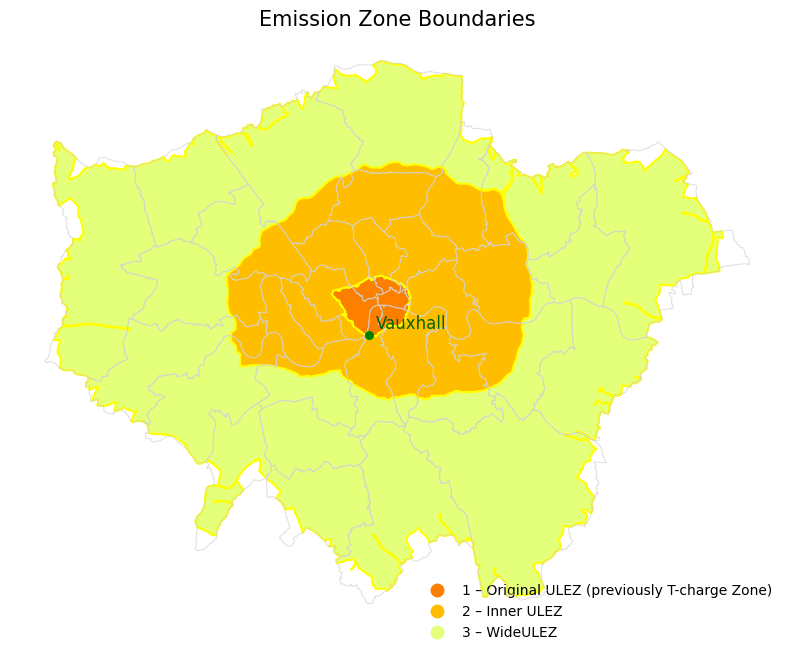

In [9]:
# Define a base map with borough boundaries
fig, ax = plt.subplots(1, figsize=(10,10))
Boroughs.plot(figsize=(10,10), color='none', edgecolor='lightgrey', alpha = 0.7,linewidth= 0.75,zorder=6, ax=ax)
ax.set_axis_off()
ax.set_title('Emission Zone Boundaries',fontsize=15)

# Add congestion zones
EZ.plot(column='Type', categorical=True, cmap = 'Wistia_r', linewidth=1.5, edgecolor='yellow', 
        legend=True,         legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,}, zorder = 1,ax=ax)

#Add Vauxhall and label
Vauxhall.plot(color='green', markersize=30, ax=ax, zorder=6);
for x, y, label in zip(Vauxhall.geometry.x, Vauxhall.geometry.y, Vauxhall.Name):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", zorder = 7, fontsize=12, color='darkgreen')

#Save Figure
plt.savefig('EmissionZoneBoundaries.png',dpi=300)

#Show
plt.show()
    


## Adding Basemap

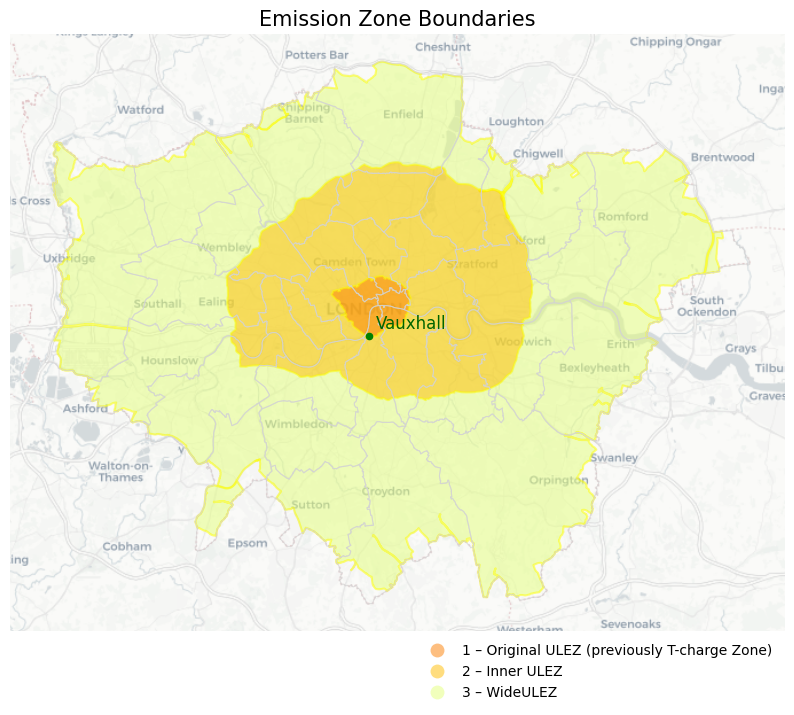

In [10]:
# Define a base map with borough boundaries
fig, ax = plt.subplots(1, figsize=(10,10))
Boroughs.plot(figsize=(10,10), color='none', edgecolor='lightgrey', alpha = 0.7,linewidth= 0.75,zorder=6, ax=ax)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False,zoom='auto')
ax.set_axis_off()
ax.set_title('Emission Zone Boundaries',fontsize=15)

# Add congestion zones
EZ.plot(column='Type', categorical=True, cmap = 'Wistia_r', linewidth=1.5, edgecolor='yellow', alpha = 0.5,
        legend=True,         legend_kwds={'bbox_to_anchor':(1,0),'fontsize':10,'frameon':False,}, zorder = 1,ax=ax)

#Add Vauxhall and label
Vauxhall.plot(color='green', markersize=20, ax=ax, zorder=6);
for x, y, label in zip(Vauxhall.geometry.x, Vauxhall.geometry.y, Vauxhall.Name):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", zorder = 7, fontsize=12, color='darkgreen')

#Save Figure
plt.savefig('EmissionZoneBoundariesMap.png',dpi=300)

#Show
plt.show()


## Boroughs and Points
Here I add the bike docking stations on the map.

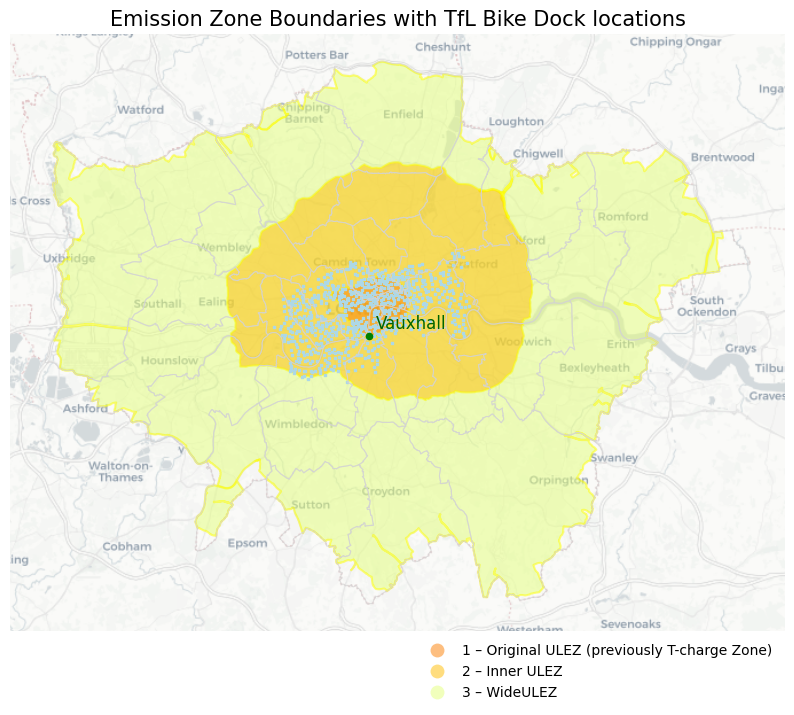

In [11]:
# Define a base map with borough boundaries
fig, ax = plt.subplots(1, figsize=(10,10))
Boroughs.plot(figsize=(10,10), color='none', edgecolor='lightgrey', alpha = 0.7,linewidth= 0.75,zorder=6, ax=ax)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False,zoom='auto')
ax.set_axis_off()
ax.set_title('Emission Zone Boundaries with TfL Bike Dock locations',fontsize=15)

# Add congestion zones
EZ.plot(column='Type', categorical=True, cmap = 'Wistia_r', linewidth=1.5, edgecolor='yellow', alpha = 0.5,
        legend=True,         legend_kwds={'bbox_to_anchor':(1,0),'fontsize':10,'frameon':False,}, zorder = 1,ax=ax)

#Add Vauxhall and label
Vauxhall.plot(color='green', markersize=20, ax=ax, zorder=6);
for x, y, label in zip(Vauxhall.geometry.x, Vauxhall.geometry.y, Vauxhall.Name):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", zorder = 7, fontsize=12, color='darkgreen')

# Add Points
BikeDocks.plot(color='lightblue', marker = 's', markersize=2, ax=ax, zorder=5, legend = True)

#Save Figure
plt.savefig('EmissionZoneBoundariesMap_BikeDocks.png',dpi=300)

#Show
plt.show()

## Zooming in

In [12]:
#Setting bounds
Vauxhall = Points.loc[[0],['Name','geometry']]
centerIN = Vauxhall.geometry

padding = 700
xlim = centerIN.x
ylim = centerIN.y

xlow = xlim[0]-padding
xhigh = xlim[0] + padding

ylow = ylim[0] - padding
yhigh = ylim[0] + padding

boundsIN = pd.DataFrame(
    {
        "Long": [xlow,xlow,xhigh,xhigh],
        "Lat": [ylow,yhigh,ylow,yhigh],
    })

bounds = gpd.GeoDataFrame(boundsIN, geometry=gpd.points_from_xy(boundsIN.Long, boundsIN.Lat))

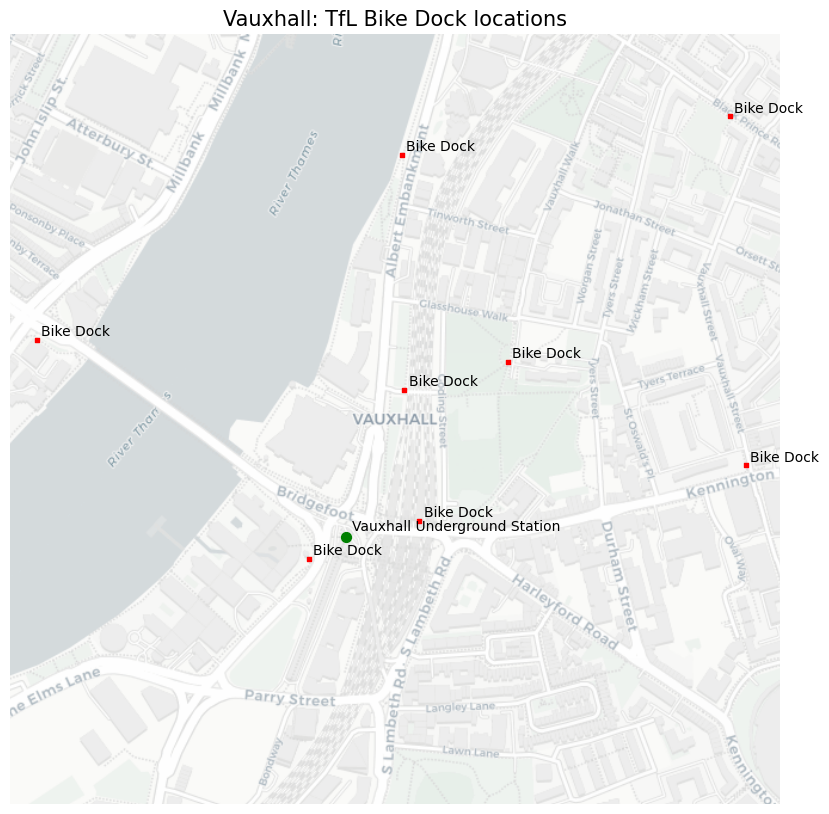

In [13]:
# Define a base map with borough boundaries
Types= ["Transport", "Weather Station"]
Points2 = Points[Points['Type'].isin(Types)]
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
ax.set_title('Vauxhall: TfL Bike Dock locations',fontsize=15)

bounds.plot(ax=ax, markersize=1,alpha = 0)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False,zoom='auto')

Points2.plot(ax=ax, color='green', markersize=50, legend=True, legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,})
BikeDocks.plot(color='red', marker = 's', markersize=5, ax=ax, zorder=5, legend=True, legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,})


# Add congestion zones
#EZ.plot(column='Type', categorical=True, cmap = 'Wistia_r', linewidth=1.5, edgecolor='yellow', alpha = 0.1,
#        legend=True,legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,}, zorder = 1,ax=ax)

for x, y, label in zip(Points2.geometry.x, Points2.geometry.y, Points2.Name):
    ax.annotate(label, xy=(x, y), xytext=(4, 4), textcoords="offset points", zorder = 8)
    
for x, y, label in zip(BikeDocks.geometry.x, BikeDocks.geometry.y, BikeDocks.Type):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder = 7)
    
#Save Figure
plt.savefig('Vauxhall_BikeDocks.png',dpi=300)

#Show
plt.show()


In [14]:


Vauxhall = Points.loc[[0],['Name','geometry']]
Vauxhall.plot(color='green', markersize=20, ax=ax, zorder=6);
BikeDocks.plot(color='lightblue', marker = 's', markersize=5, ax=ax, zorder=5)
UULEZ.plot(color = 'red',edgecolor = 'red', alpha = 0.3, linewidth= 2, ax=ax, zorder = 4)
InnerULEZ.plot(color='lightgreen', edgecolor='green',alpha = 0.54, linewidth= 2, ax=ax, zorder=3)
WideULEZ.plot(color='lightblue', edgecolor='blue', alpha = 0.3, linewidth= 2, ax=ax, zorder=2)

for x, y, label in zip(Vauxhall.geometry.x, Vauxhall.geometry.y, Vauxhall.Name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder = 7)
    

<Figure size 640x480 with 0 Axes>

## Adding Zones

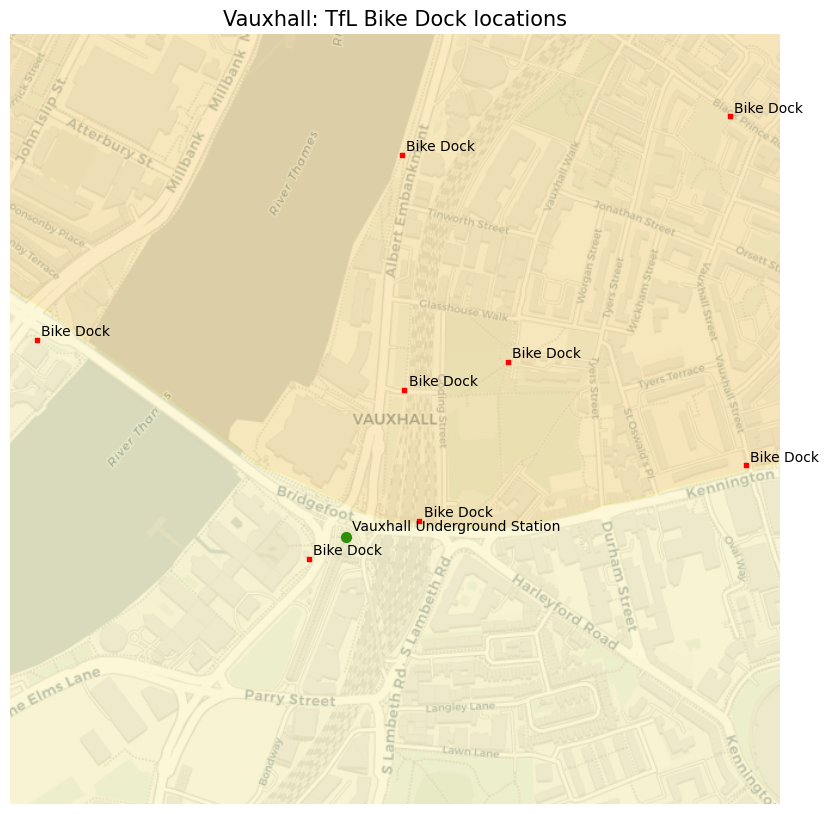

In [15]:
# Define a base map with borough boundaries
Types= ["Transport", "Weather Station"]
Points2 = Points[Points['Type'].isin(Types)]
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
ax.set_title('Vauxhall: TfL Bike Dock locations',fontsize=15)

bounds.plot(ax=ax, markersize=1,alpha = 0)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False,zoom='auto')

Points2.plot(ax=ax, color='green', markersize=50, legend=True, legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,})
BikeDocks.plot(color='red', marker = 's', markersize=5, ax=ax, zorder=5, legend=True, legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,})


# Add congestion zones
EZ.plot(column='Type', categorical=True, cmap = 'Wistia_r', linewidth=1.5, edgecolor='yellow', alpha = 0.1,
        legend=False,legend_kwds={'bbox_to_anchor':(1,0.1),'fontsize':10,'frameon':False,}, zorder = 1,ax=ax)

for x, y, label in zip(Points2.geometry.x, Points2.geometry.y, Points2.Name):
    ax.annotate(label, xy=(x, y), xytext=(4, 4), textcoords="offset points", zorder = 8)
    
for x, y, label in zip(BikeDocks.geometry.x, BikeDocks.geometry.y, BikeDocks.Type):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder = 7)
    
#Save Figure
plt.savefig('Vauxhall_BikeDocks_EZ.png',dpi=300)

#Show
plt.show()
